# The Machinery

For proof of concept, I consider Gaussian generative models with MLP discriminator. The Gaussian generative models take data from n-dimensional latent space $z \sim \mathcal{N}(0, I)$ to arbitrary n-dimensional $\mathcal{N}(\mu, \Sigma)$ by learned affine transformation.

In [1]:
import numpy as np
import theano as theano
import theano.tensor as T

/home/hudson/.local/lib/python3.5/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda0: GeForce GTX 1080 (0000:02:00.0)


In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('/home/hudson/Projects/GAMM')
from lib.utils import log_progress

## Generator

In [4]:
class GaussianGenerator(object):
    def __init__(self, input, ndim= 1, mu=None, sig=None, scale=1):
        if mu is None:
            mu = scale*np.random.randn(ndim,).astype(theano.config.floatX)
        mu = theano.shared(value=mu, name='mu', borrow=True)
        if sig is None:
            sig = np.random.randn(ndim, ndim).astype(theano.config.floatX)
        sig = theano.shared(value=sig, name='sigma', borrow=True)
        self.mu = mu
        self.sig = sig
        
        ndim = mu.shape[0].eval()
        self.ndim = ndim
        
        self.params = [self.mu, self.sig]
        
        self.out = (T.dot(self.sig, input).T + self.mu.T)
        
    def sample(self, n=1):
        z = np.random.randn(self.ndim, n).astype(theano.config.floatX)
        out = (T.dot(self.sig, z).T + self.mu.T)
        return(out)

## Discriminator

In [5]:
class Hidden(object):
    #http://deeplearning.net/tutorial/mlp.html
    def __init__(self, input, n_in, n_out, W = None, b = None,
                 activation = T.tanh, rng = np.random.RandomState()):
        
        self.input = input
        
        if W is None:
            W_range = np.sqrt(6. / (n_in + n_out))
            W_values = np.asarray(
                rng.uniform(
                    low = -W_range,
                    high = W_range,
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            if activation == T.nnet.sigmoid:
                W_values *= 4
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b
        
        # parameters of the model
        self.params = [self.W, self.b]
        
        lin_output = T.dot(input, self.W) + self.b
        self.output = (
            lin_output if activation is None
            else activation(lin_output)
        )

In [6]:
class LogisticRegression(object):
    def __init__(self, input, n_in, n_out, W = None, b = None,
                 rng = np.random.RandomState()):
        self.input = input
        
        if W is None:
            W_range = np.sqrt(6. / (n_in + n_out))
            W_values = np.asarray(
                rng.uniform(
                    low = -W_range,
                    high = W_range,
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=W_values, name='W', borrow=True)

        if b is None:
            b_values = np.zeros((n_out,), dtype=theano.config.floatX)
            b = theano.shared(value=b_values, name='b', borrow=True)

        self.W = W
        self.b = b
        
        self.params = [self.W, self.b]
        
        self.lin = T.dot(input, self.W) + b
        
        self.p_y = T.nnet.softmax(self.lin) 
            
        self.y_pred = T.argmax(self.p_y, axis=1)

In [7]:
class MLP(object):
    def __init__(self, input, n_in, n_out, n_hidden=300, params = None,
                 rng = np.random.RandomState()):
        self.input = input
        self.n_in = n_in
        self.n_out = n_out
        self.n_hidden = n_hidden
        self.rng = rng
        
        hidden = Hidden(
            input,
            n_in, n_hidden,
            W = None if params is None else params[0],
            b = None if params is None else params[1],
            rng = rng
        )
        self.hidden = hidden
        
        out = LogisticRegression(
            self.hidden.output,
            n_hidden, n_out,
            W = None if params is None else params[2],
            b = None if params is None else params[3],
            rng = rng
        )
        self.out = out
        
        self.lin = out.lin
        self.p_y = out.p_y
        self.y_pred = out.y_pred
        
        self.params = hidden.params + out.params
        
    def predict(self, x):
        mlp = MLP(x, self.n_in, self.n_out, self.n_hidden, self.params, self.rng)
        return(mlp.y_pred.eval())
    
    def prob(self, x, temp = 1):
        mlp = MLP(x, self.n_in, self.n_out, self.n_hidden, self.params, self.rng)
        return(T.nnet.softmax(mlp.lin / temp).eval())

##### Distribution to fit. Mixture of Gaussians

In [8]:
z = T.matrix('z')
n = 10000
mixture = np.array([1, 1, 1])
mixture = mixture/sum(mixture)
x = []
for proportion in mixture:
    g = GaussianGenerator(z,ndim=2, scale = len(mixture)**2)
    z = g.sample(int(proportion * n)).eval()
    x.append(z)
x = np.vstack(x).astype('float32')

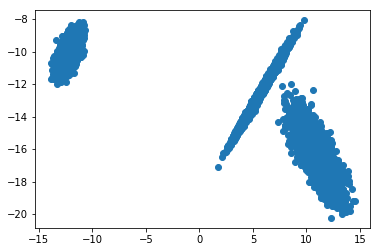

In [9]:
plt.scatter(x[:,0], x[:,1])

### Model fitting

In [10]:
def decision(X, model, h=.05):
    # X - some data in 2dimensional np.array
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # here "model" is your model's prediction (classification) function
    Z = model(np.c_[xx.ravel(), yy.ravel()]) 

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    #plt.axis('off')
    
def plotDecision(X, gens, crit):
    gX = []
    gY = []

    plt.figure()
    for gen in gens:
        gx = gen.sample(1000).eval()
        gX.append(gx)
    decision(np.vstack((X, np.vstack(gX))), crit.predict)
    plt.scatter(X[:,0], X[:,1])
    for gx in gX:
        plt.scatter(gx[:,0], gx[:,1], alpha = .6)    
    plt.show()

In [11]:
def Adam(cost, params, lr=0.0002, b1=0.9, b2=0.999, e=1e-8, c=None):
    #https://gist.github.com/Newmu/acb738767acb4788bac3
    #Standard literature says b1=.9
    #DCGAN paper says b1 = .5
    b1 = 1-b1
    b2 = 1-b2
    updates = []
    grads = T.grad(cost, params)
    i = theano.shared(np.float32(0.))
    i_t = i + 1.
    fix1 = 1. - (1. - b1)**i_t
    fix2 = 1. - (1. - b2)**i_t
    lr_t = lr * (T.sqrt(fix2) / fix1)
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        m_t = (b1 * g) + ((1. - b1) * m)
        v_t = (b2 * T.sqr(g)) + ((1. - b2) * v)
        g_t = m_t / (T.sqrt(v_t) + e)
        p_t = p - (lr_t * g_t) if c is None else T.clip(p - (lr_t * g_t), -c, c)
        updates.append((m, m_t))
        updates.append((v, v_t))
        updates.append((p, p_t))
    updates.append((i, i_t))
    return updates

def gradDesc(cost, params, lr=.00005):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        update = p - lr * g
        updates.append((p, update))
    return updates

In [14]:
def mixtureTrain(X, k = 3, batch_size = 100, iters = 10000, alpha = .005, n_hidden = 300,
                 T0 = 1,
         rng = np.random.RandomState()):
    x = T.matrix('x')
    z = T.matrix('z')

    ndim = X.shape[1]    
    
    print("Building model...")
    ################### Generator ###################
    
    gens = [GaussianGenerator(z, ndim=ndim, scale = k**2)
            for i in range(k)]
    genParams = [gen.params for gen in gens]
    genCrits = np.array([MLP(gens[i].out, ndim, 2, n_hidden = n_hidden)
                    for i in range(k)])
    critParams = [genCrit.params for genCrit in genCrits]
    realCrits = np.array([MLP(x, ndim, 2, n_hidden = n_hidden, params = critParams[i])
                    for i in range(k)])

    critLosses = [-T.mean(T.log(realCrits[i].p_y[:,0]))
                  -T.mean(T.log(genCrits[i].p_y[:,1]))
                  for i in range(k)]
    genLosses = [T.mean(T.log(genCrits[i].p_y[:,1]))
                  for i in range(k)]
    
    critUpdates = [Adam(critLosses[i], critParams[i], lr=alpha)
                   for i in range(k)]
    genUpdates = [Adam(genLosses[i], genParams[i], lr=alpha)
                  for i in range(k)]
    
    trainGens = [
        theano.function(
            inputs = [], 
            outputs = genLosses[i], 
            updates = genUpdates[i],
            givens = {z: np.random.randn(X.shape[1], batch_size)
                                      .astype(theano.config.floatX)
                     }
        )
        for i in range(k)
    ]
    trainCrits = [
        theano.function(
            inputs = [x], 
            outputs = critLosses[i], 
            updates = critUpdates[i],
            givens = {z: np.random.randn(X.shape[1], batch_size)
                                      .astype(theano.config.floatX)
                     }
        )
        for i in range(k)
    ]
    #################################################
    
    
    #################### Mixture ####################
    
    #Mixture softmax
    mixCrit = MLP(x, ndim, k, n_hidden = n_hidden)
    mixParams = mixCrit.params
    mixCrits = [MLP(gens[i].out, ndim, k, n_hidden = n_hidden, params = mixParams) for i in range(k)]
    
    #Mixture critic loss
    mixLoss = -T.sum(
        [T.mean(T.log(mixCrits[i].p_y[:,i])) for i in range(k)]
    )
    
    #Save mixture loss graph
    if False:
        theano.printing.pydotprint(mixLoss, outfile="mixLoss.png", var_with_name_simple=True)  
    
    #Mixture critic updates
    mixUpdates = gradDesc(mixLoss, mixParams, lr=alpha)
    trainMix = theano.function(
            inputs = [],
            outputs = mixLoss,
            updates = mixUpdates,
            givens = {z: np.random.randn(X.shape[1], batch_size)
                                      .astype(theano.config.floatX)
                     }
    )
    
    #################################################
    print("Done!")
    
    print('Begin training...')
    
    mixPlot = []
    critPlot = []
    
    for iter in log_progress(range(iters), every=5):    
        if iter != 1 and iter % 500 == 1 or iter == 26:
            plt.figure()
            plt.plot(mixPlot)
            plt.title("Mixture Critic Loss")
            plt.figure()
            plt.plot(critPlot)
            plt.title("Generator Critic Losses")
            plotDecision(X, gens, mixCrit)
        mixiters = 100 if iter < 25 or iter % 500 == 0 else 1
        for i in range(mixiters):
            mixPlot.append(trainMix())
        
        #gen/crit
        #predictions = mixCrit.predict(X)
        py = mixCrit.prob(X)
        p = (py / py.sum(axis = 0))
        iterCrit = []
        for i in range(k):
            xG = X[np.random.choice(len(p),size = batch_size, p=p[:,i])]
            iterCrit.append(trainCrits[i](xG))
            trainGens[i]()
            
        critPlot.append(iterCrit)
                
    plt.figure()
    plt.plot(mixPlot)
    plt.title("Mixture Critic Loss")
    plt.figure()
    plt.plot(critPlot)
    plt.title("Generator Critic Losses")
    plotDecision(X, gens, mixCrit)
    
    return([gens, mixCrit])

Building model...
Done!
Begin training...


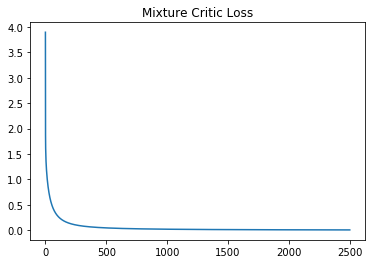

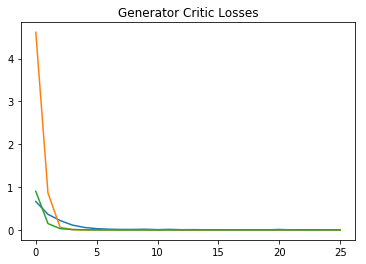

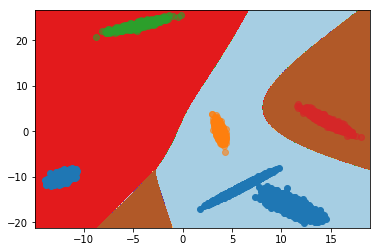

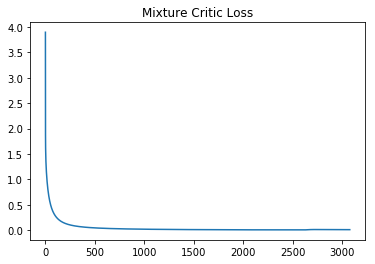

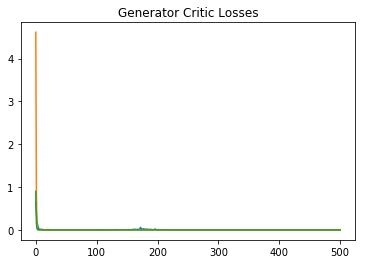

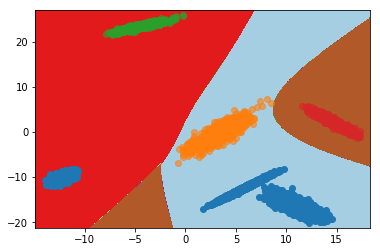

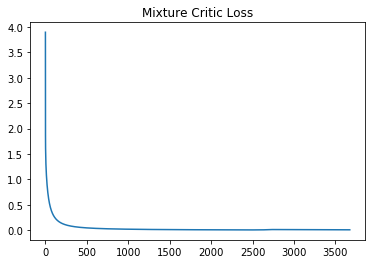

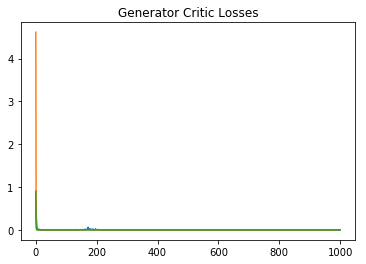

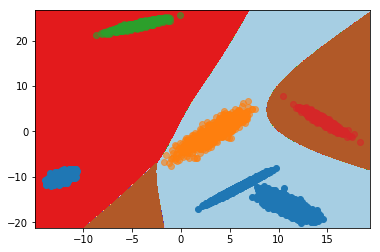

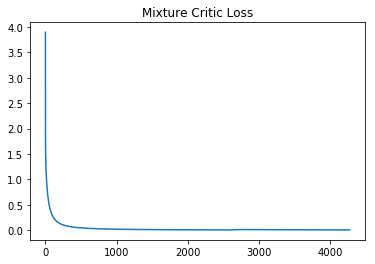

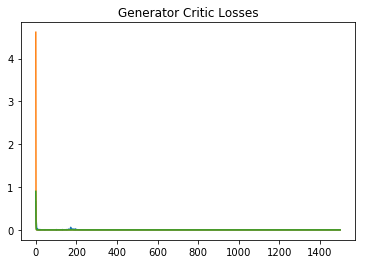

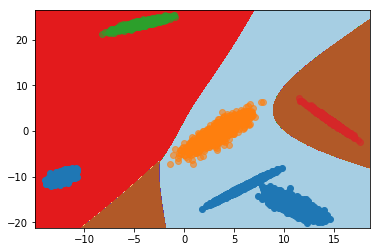

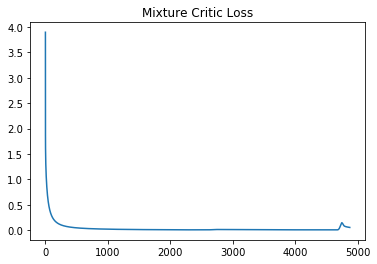

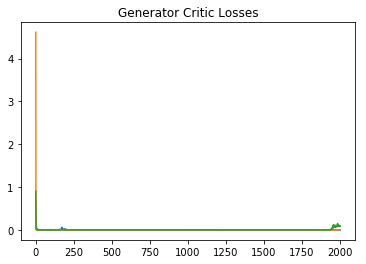

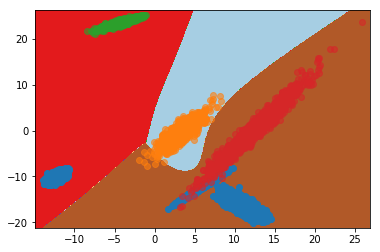

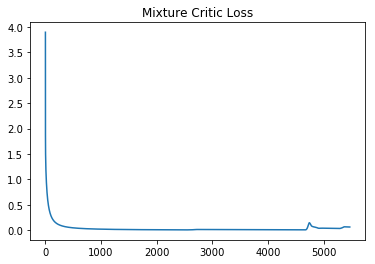

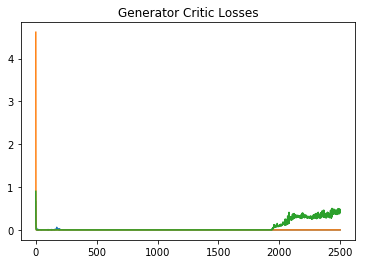

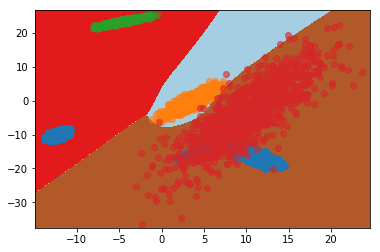

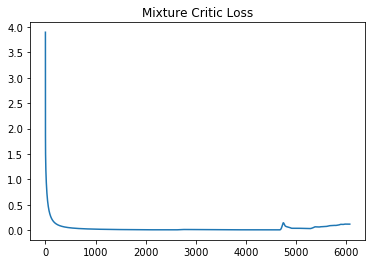

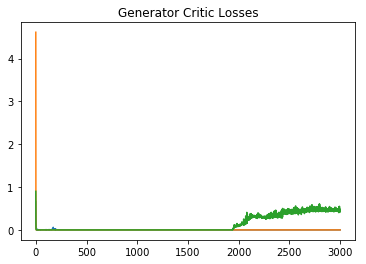

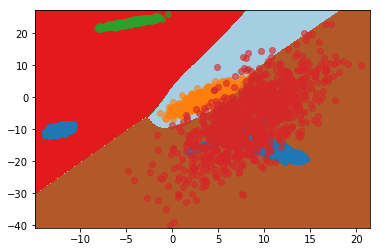

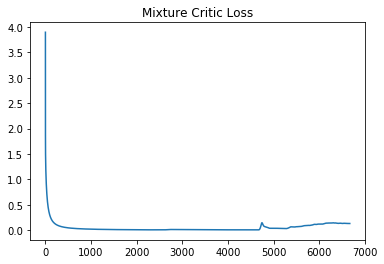

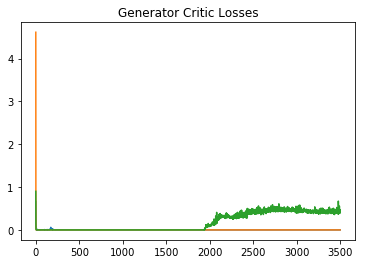

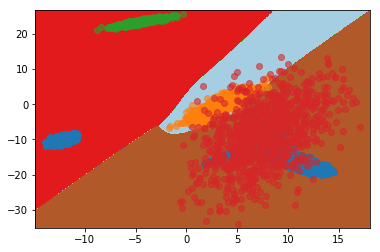

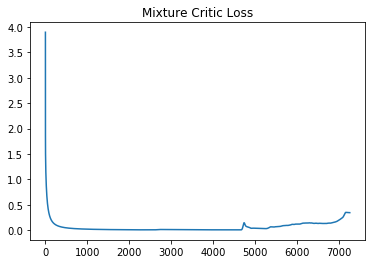

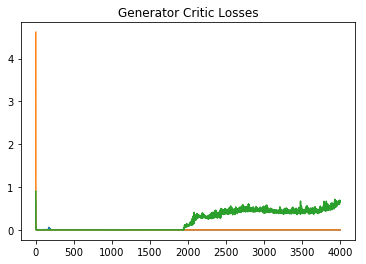

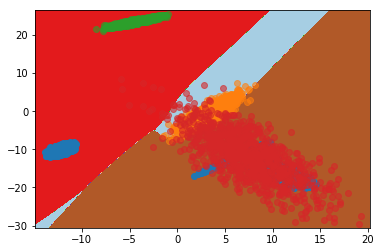

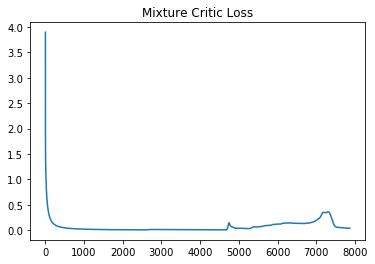

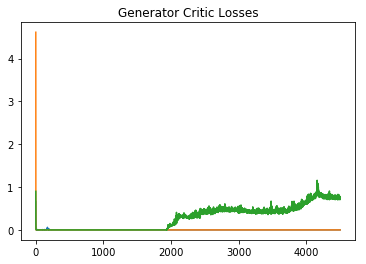

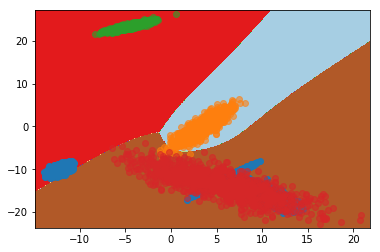

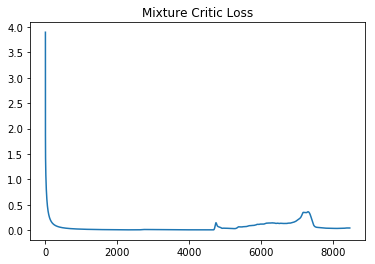

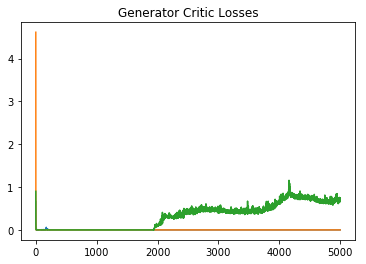

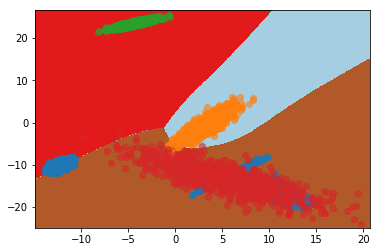

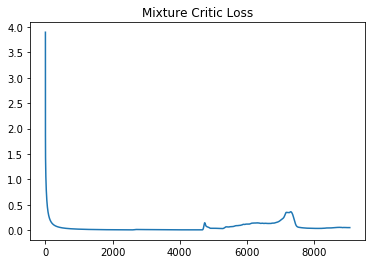

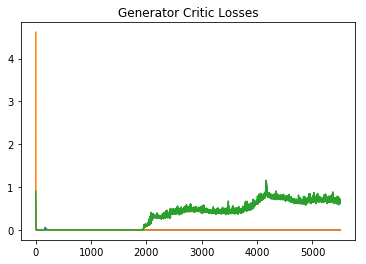

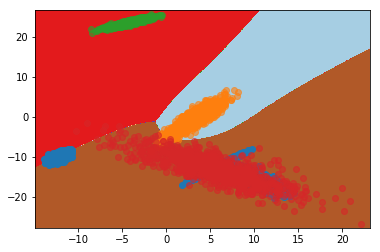

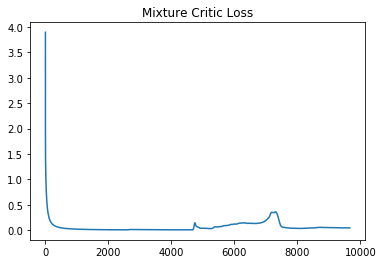

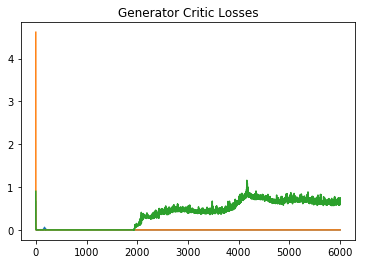

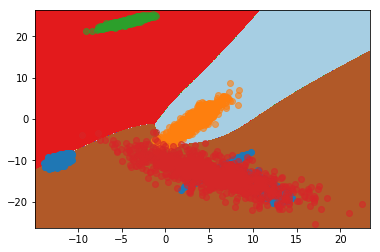

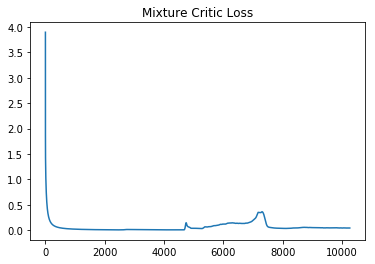

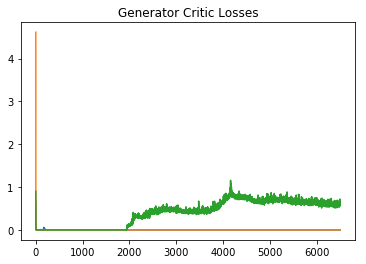

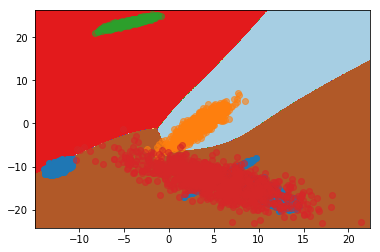

In [ ]:
gens, mixCrit = mixtureTrain(x, k = 3, batch_size = 100, iters = 10000, alpha = .005, n_hidden = 300)